In [1]:
import numpy as np

data = np.load("data.npy")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import trange


def compute_energy(F_i, F_total):

    # if F_total == 0 or F_i == 0:
    #     return 0.0  
    
    # E_nu_i = abs(70 - 60 * torch.sqrt(F_i / F_total))
    E_nu_i = 70 - 60 * torch.sqrt(F_i / F_total)   

    if E_nu_i < 0:
        return 0.0
    elif E_nu_i > 60:
        return 60.0
    else:
        return E_nu_i



X = torch.tensor(data[:, :9], dtype=torch.float32)  
y_main = torch.tensor(data[:, 9:17], dtype=torch.float32)  



F_nue_total = torch.tensor(data[:, 1], dtype=torch.float32)  
F_nue_i = torch.tensor(data[:, 4], dtype=torch.float32)  

F_nueb_total = torch.tensor(data[:, 2], dtype=torch.float32)  
F_nueb_i = torch.tensor(data[:, 6], dtype=torch.float32)  


E_nue_i = torch.tensor([compute_energy(F_nue_i[i], F_nue_total[i]) for i in range(len(F_nue_i))], dtype=torch.float32).unsqueeze(1)

E_nueb_i = torch.tensor([compute_energy(F_nueb_i[i], F_nueb_total[i]) for i in range(len(F_nueb_i))], dtype=torch.float32).unsqueeze(1)


X = torch.cat([X, E_nue_i, E_nueb_i], dim=1)

y_reg = torch.tensor(data[:, 17:20], dtype=torch.float32)  




In [4]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt


Y = y_main.cpu().detach().numpy()
X_np = X.cpu().detach().numpy()

valid_mask = np.isfinite(X_np).all(axis=1) & np.isfinite(Y).all(axis=1)
X_np = X_np[valid_mask]
Y = Y[valid_mask]


def safe_inv(x, power=1, eps=1e-6, max_value=1e6):
    x_safe = np.clip(np.abs(x), eps, None)
    return np.clip(1.0 / (x_safe ** power), -max_value, max_value)


custom_funcs = [
    lambda x: np.tan(np.clip(x, -200, 200)),                          

]

custom_func_names = [
    lambda x: f"tan({x})",
    # lambda x: f"log1p(|{x}|)",
    # lambda x: f"exp(-{x}^2)",
    # lambda x: f"1/({x})",
    # lambda x: f"1/({x}^2)",
    # lambda x: f"1/({x}^3)"
]

custom_lib = ps.CustomLibrary(
    library_functions=custom_funcs,
    function_names=custom_func_names,
    include_bias=False
)


poly_lib = ps.PolynomialLibrary(degree=1)
fourier_lib = ps.FourierLibrary(n_frequencies=1)
# library = poly_lib + fourier_lib + custom_lib
library = poly_lib + fourier_lib



model = ps.SINDy(
    feature_library=library,
    optimizer=ps.STLSQ(threshold=0.01)
)
model.fit(X_np, x_dot=Y)
model.print()


Y_pred = model.predict(X_np)
mse = np.mean((Y - Y_pred) ** 2)
print(f"\n MSE: {mse:.4e}")


(x0)' = 0.006 1 + -0.007 x0 + -0.027 x1 + 0.062 x2 + 0.008 x4 + -0.001 x5 + 0.341 x7 + -0.019 x8 + 0.012 cos(1 x0) + -0.020 sin(1 x1) + 0.023 cos(1 x1) + 0.046 sin(1 x2) + -0.033 cos(1 x2) + 0.006 sin(1 x4) + 0.001 cos(1 x4) + -0.001 sin(1 x5) + 0.006 cos(1 x5) + -0.017 sin(1 x8) + 0.015 cos(1 x8)
(x1)' = -0.012 x0 + -0.021 x1 + 0.041 x2 + 0.028 x4 + 0.065 x7 + 0.036 x8 + 0.030 sin(1 x0) + 0.014 cos(1 x0) + -0.017 sin(1 x1) + 0.011 cos(1 x1) + 0.030 sin(1 x2) + -0.030 cos(1 x2) + 0.025 sin(1 x4) + -0.013 cos(1 x4) + -0.002 cos(1 x5) + 0.060 sin(1 x7) + -0.023 cos(1 x7) + 0.030 sin(1 x8) + -0.020 cos(1 x8)
(x2)' = 0.003 1 + 0.027 x0 + -0.019 x1 + 0.038 x2 + 0.002 x5 + -0.003 x6 + 0.341 x7 + -0.005 x8 + -0.020 cos(1 x0) + -0.014 sin(1 x1) + 0.015 cos(1 x1) + 0.028 sin(1 x2) + -0.021 cos(1 x2) + 0.003 cos(1 x3) + 0.002 sin(1 x5) + 0.003 cos(1 x5) + -0.003 sin(1 x6) + 0.004 cos(1 x6) + -0.004 sin(1 x8) + 0.005 cos(1 x8)
(x3)' = 0.002 1 + 0.007 x0 + 0.001 x1 + 0.004 x2 + 0.035 x6 + 0.065 x7

In [5]:
import pysindy as ps
import re


input_features = [f"x_{i}" for i in range(X_np.shape[1])]  


feature_names = model.feature_library.get_feature_names(input_features)


coefs = model.coefficients()


expressions = []
for i, coef_row in enumerate(coefs):
    terms = []
    for coef, fname in zip(coef_row, feature_names):
        if abs(coef) > 1e-12:
            if fname == '1':
                terms.append(f"{coef:.16g}")
            else:
                terms.append(f"{coef:.16g}*({fname})")
    expr = " + ".join(terms) if terms else "0.0"
    expressions.append(expr)


def fix_expr_str(expr):
    import re

    expr = expr.replace('^', '**')


    expr = re.sub(r'(?<=\w)\s+(?=\w)', '*', expr)

    expr = re.sub(r'(\b(?:sin|cos|tan|exp|log))\(([^)]*?)\)',
                  lambda m: m.group(1) + '(' + re.sub(r'(?<=\d)\s+(?=x_\d)', '*', m.group(2)) + ')',
                  expr)

    return expr



analytic_model = ([fix_expr_str(e) for e in expressions], input_features)



print("analytic_model = ([")
for expr in analytic_model[0]:
    print(f'  "{expr}",')
print(f"], {analytic_model[1]})")


analytic_model = ([
  "0.005836977157741785 + -0.006795801222324371*(x_0) + -0.02682569622993469*(x_1) + 0.06150002032518387*(x_2) + 0.0003809592453762889*(x_3) + 0.007929936051368713*(x_4) + -0.001097792643122375*(x_5) + 0.3408764898777008*(x_7) + -0.0194508321583271*(x_8) + 0.0122583219781518*(cos(1*x_0)) + -0.02033591270446777*(sin(1*x_1)) + 0.02349808812141418*(cos(1*x_1)) + 0.04621934145689011*(sin(1*x_2)) + -0.03342309221625328*(cos(1*x_2)) + 0.0003762061824090779*(sin(1*x_3)) + 0.006238061934709549*(sin(1*x_4)) + 0.0007248902693390846*(cos(1*x_4)) + -0.001072634477168322*(sin(1*x_5)) + 0.006039195694029331*(cos(1*x_5)) + -0.01659741625189781*(sin(1*x_8)) + 0.01507321186363697*(cos(1*x_8))",
  "-0.01207210402935743*(x_0) + -0.02130286395549774*(x_1) + 0.04082005843520164*(x_2) + -0.00043690693564713*(x_3) + 0.02755273506045341*(x_4) + 0.06489140540361404*(x_7) + 0.03575913608074188*(x_8) + 0.0297231450676918*(sin(1*x_0)) + 0.01398618891835213*(cos(1*x_0)) + -0.01652290299534798*(

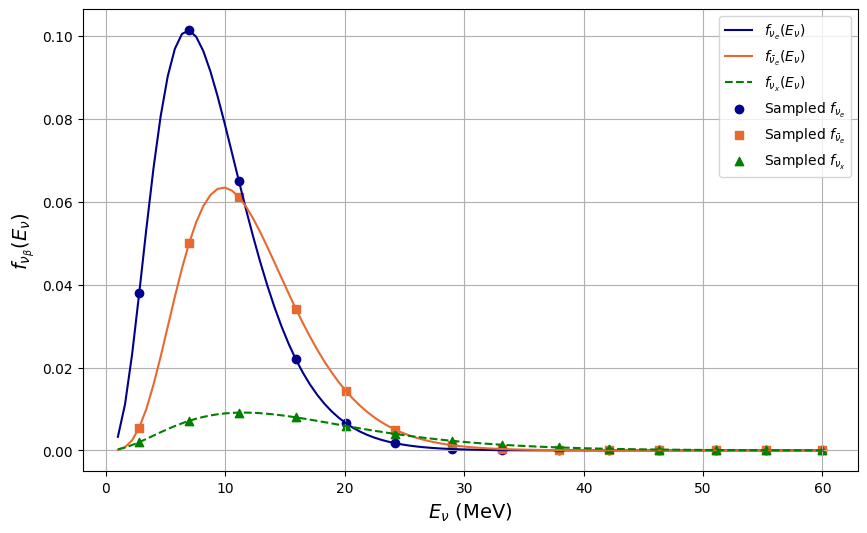

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import pandas as pd


L_nu_e = 1
L_nu_bar_e = 1
L_nu_x = 0.33
E_nu_e_avg = 9
E_nu_bar_e_avg = 12
E_nu_x_avg = 16.5
n_nu_e = 3.2
n_nu_bar_e = 4.5
n_nu_x = 2.3


T_nu_e = E_nu_e_avg / (1 + n_nu_e)
T_nu_bar_e = E_nu_bar_e_avg / (1 + n_nu_bar_e)
T_nu_x = E_nu_x_avg / (1 + n_nu_x)


def f_nu(E_nu, T_nu, n_nu):
    return (1 / (T_nu * gamma(1 + n_nu))) * (E_nu / T_nu)**n_nu * np.exp(-E_nu / T_nu)


E_nu = np.linspace(1, 60, 100)


f_nu_e = f_nu(E_nu, T_nu_e, n_nu_e)
f_nu_bar_e = f_nu(E_nu, T_nu_bar_e, n_nu_bar_e) * ((E_nu_e_avg / E_nu_bar_e_avg) / (L_nu_e / L_nu_bar_e)) 
f_nu_x = f_nu(E_nu, T_nu_x, n_nu_x) * ((E_nu_e_avg / E_nu_x_avg) / (L_nu_e / L_nu_x))




num_points = 14
indices = np.linspace(3, len(E_nu)-1, num_points, dtype=int)
E_nu_sampled = E_nu[indices]
n_nue_sampled = f_nu_e[indices]
n_nueb_sampled = f_nu_bar_e[indices]
n_nux_sampled = f_nu_x[indices]



threshold_nue = 8e-9
threshold_nueb = 8e-9
threshold_nux = 8e-9

n_nue_sampled = np.maximum(n_nue_sampled, threshold_nue)
n_nueb_sampled = np.maximum(n_nueb_sampled, threshold_nueb)
n_nux_sampled = np.maximum(n_nux_sampled, threshold_nux)


F_nue_tot = 0.5
F_nueb_tot = 0.7
F_nux_tot = 0.8

F_nue_sampled = F_nue_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2
F_nueb_sampled = F_nueb_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2
F_nux_sampled = F_nux_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2


alpha_sampled = n_nueb_sampled/ n_nue_sampled


plt.figure(figsize=(10, 6))
plt.plot(E_nu, f_nu_e, label=r'$f_{\nu_e}(E_\nu)$', color=(0, 0, 139/255), linestyle='-')
plt.plot(E_nu, f_nu_bar_e, label=r'$f_{\bar{\nu}_e}(E_\nu)$', color=(232/255, 105/255, 48/255), linestyle='-')
plt.plot(E_nu, f_nu_x, label=r'$f_{\nu_x}(E_\nu)$', color='green', linestyle='--')


plt.scatter(E_nu_sampled, n_nue_sampled, color=(0, 0, 139/255), marker='o', label=r'Sampled $f_{\nu_e}$')
plt.scatter(E_nu_sampled, n_nueb_sampled, color=(232/255, 105/255, 48/255), marker='s', label=r'Sampled $f_{\bar{\nu}_e}$')
plt.scatter(E_nu_sampled, n_nux_sampled, color='green', marker='^', label=r'Sampled $f_{\nu_x}$')


#plt.title(r"Neutrino Spectra with Sampled Points", fontsize=16)
plt.xlabel(r"$E_\nu$ (MeV)", fontsize=14)
plt.ylabel(r"$f_{\nu_\beta}(E_\nu)$", fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()


data_test = {
    "alpha": alpha_sampled,
    "F_nue_tot": np.full(num_points, F_nue_tot),
    "F_nueb_tot": np.full(num_points, F_nueb_tot),
    "n_nue": n_nue_sampled,
    "F_nue": F_nue_sampled,
    "n_nueb": n_nueb_sampled,
    "F_nueb": F_nueb_sampled,
    "n_nux": n_nux_sampled,
    "F_nux": F_nux_sampled,
    "E_nu": E_nu_sampled,
    "E_nub": E_nu_sampled,
}


df = pd.DataFrame(data_test)


matrix_data = df.values.tolist()




In [7]:
import torch
import numpy as np
import math

def check_parentheses(expr: str):
    bal = 0
    for i, ch in enumerate(expr):
        if ch == '(':
            bal += 1
        elif ch == ')':
            bal -= 1
            if bal < 0:
                return False, i
    return bal == 0, None

def parse_analytic_model(model_structure):
    expr_list, var_names = model_structure
    if not isinstance(expr_list, (list, tuple)):
        raise TypeError("expr_list must be list or tuple")
    if not isinstance(var_names, (list, tuple)):
        raise TypeError("var_names must be list or tuple")
    return expr_list, var_names

def eval_analytic_model(test_X, model_structure):
    expr_list, var_names = parse_analytic_model(model_structure)

    # check format
    compiled = []
    for idx, expr in enumerate(expr_list):
        ok, pos = check_parentheses(expr)
        if not ok:
            raise ValueError(f"#{idx} error, pos in {pos}：\n{expr}")
        try:
            compiled.append(compile(expr, '<expr>', 'eval'))
        except SyntaxError as e:
            raise SyntaxError(f" #{idx} syntax error：\n{expr}\n{e}")


    arr = test_X.cpu().numpy() if hasattr(test_X, 'cpu') else np.asarray(test_X)


    math_funcs = {
        "sin":   math.sin,
        "cos":   math.cos,
        "tan":   math.tan,
        "exp":   math.exp,
        "log":   math.log,
        "tanh":  math.tanh,
        "Abs":   abs,           
        "abs":   abs,           
        "sqrt":  math.sqrt,     
        "pow":   pow,           
        "floor": math.floor,    
        "ceil":  math.ceil,     #
    }
    math_funcs["__builtins__"] = {}

    outputs = []
    for row in arr:

        ctx = math_funcs.copy()
        ctx.update({var_names[i]: float(row[i]) for i in range(len(var_names))})
        vals = [eval(co, ctx) for co in compiled]
        outputs.append(vals)

    out = np.array(outputs, dtype=np.float32)
    return torch.tensor(out, device=test_X.device) if hasattr(test_X, 'device') else out


In [8]:
test_X = torch.tensor([row[0:11] for row in matrix_data], dtype=torch.float32)

In [9]:
# — example usage — 

analytic_outputs_analytic = eval_analytic_model(test_X, analytic_model)

predictions_nue_analytic   = analytic_outputs_analytic[:, 0:2]
predictions_nueb_analytic  = analytic_outputs_analytic[:, 2:4]
predictions_nux_analytic   = analytic_outputs_analytic[:, 4:6]
predictions_nuxb_analytic  = analytic_outputs_analytic[:, 6:8]
print("Analytic I0/I1 ν_e:", predictions_nue_analytic.cpu().numpy())

Analytic I0/I1 ν_e: [[ 0.05223299  0.0790303 ]
 [ 0.0542645   0.0710822 ]
 [ 0.05207894  0.05988552]
 [ 0.04452405  0.03728765]
 [ 0.03561098  0.00563829]
 [ 0.02823533 -0.03493235]
 [ 0.02657417 -0.07893989]
 [ 0.03181892 -0.09840215]
 [ 0.03751104 -0.09102423]
 [ 0.03116281 -0.08003813]
 [ 0.01205067 -0.10054911]
 [-0.00658542 -0.16568667]
 [-0.00418399 -0.2003541 ]
 [ 0.04114478 -0.07779524]]


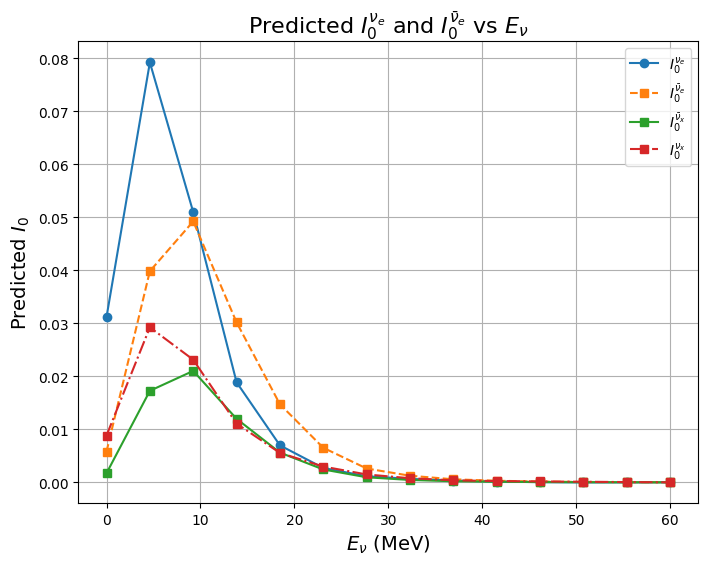

In [10]:


I0_nue0_analytic = predictions_nue_analytic[:, 0].cpu().numpy() 
I0_nueb0_analytic = predictions_nueb_analytic[:, 0].cpu().numpy() 
I0_nux0_analytic = predictions_nux_analytic[:, 0].cpu().numpy() 
I0_nuxb0_analytic = predictions_nuxb_analytic[:, 0].cpu().numpy() 

E_nu_values = np.linspace(0, 60, len(I0_nue0_analytic))



norm_par = (n_nue_sampled + n_nux_sampled + n_nueb_sampled + n_nux_sampled) / (I0_nue0_analytic + I0_nux0_analytic + I0_nueb0_analytic + I0_nuxb0_analytic)

I0_nue1_analytic =  I0_nue0_analytic * (n_nue_sampled + n_nux_sampled) / (I0_nue0_analytic + I0_nux0_analytic)
I0_nueb1_analytic = I0_nueb0_analytic * (n_nueb_sampled + n_nux_sampled) / (I0_nueb0_analytic + I0_nuxb0_analytic)
I0_nux1_analytic = I0_nux0_analytic * (n_nue_sampled + n_nux_sampled) / (I0_nue0_analytic + I0_nux0_analytic)
I0_nuxb1_analytic = I0_nuxb0_analytic * (n_nueb_sampled + n_nux_sampled) / (I0_nueb0_analytic + I0_nuxb0_analytic)




plt.figure(figsize=(8,6))
plt.plot(E_nu_values, I0_nue1_analytic, label=r"$I_0^{\nu_e}$", marker='o', linestyle='-')
plt.plot(E_nu_values, I0_nueb1_analytic, label=r"$I_0^{\bar{\nu}_e}$", marker='s', linestyle='--')
plt.plot(E_nu_values, I0_nuxb1_analytic, label=r"$I_0^{\bar{\nu}_x}$", marker='s', linestyle='-')
plt.plot(E_nu_values, I0_nux1_analytic, label=r"$I_0^{\nu_x}$", marker='s', linestyle='-.')

plt.xlabel(r"$E_\nu$ (MeV)", fontsize=14)
plt.ylabel(r"Predicted $I_0$", fontsize=14)
# plt.yscale('log')
plt.title(r"Predicted $I_0^{\nu_e}$ and $I_0^{\bar{\nu}_e}$ vs $E_\nu$", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import numpy as np


data_to_save = {
    'E_nu': np.array(E_nu_values),
    'I0_nue': I0_nue1_analytic,
    'I0_nueb': I0_nueb1_analytic,
    'I0_nux': I0_nux1_analytic,
    'I0_nuxb': I0_nuxb1_analytic
}


np.save('I0_vs_Enu_analytic.npy', data_to_save)


In [12]:
loaded_test_data = np.load('I0_vs_Enu_analytic.npy', allow_pickle=True).item()

E_nu_values = loaded_test_data['E_nu']
I0_nue = loaded_test_data['I0_nue']
I0_nueb = loaded_test_data['I0_nueb']
I0_nux = loaded_test_data['I0_nux']
I0_nuxb = loaded_test_data['I0_nuxb']

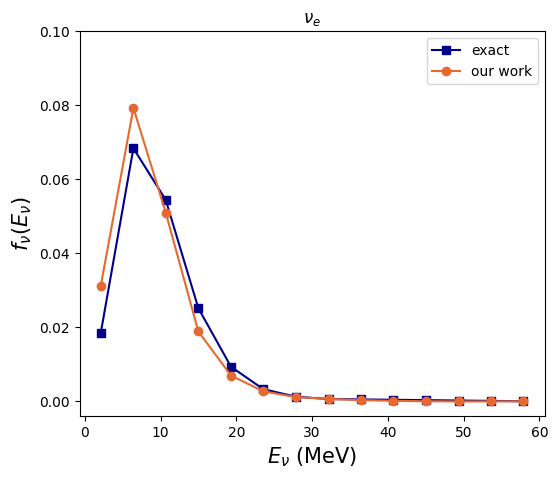

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nue = np.loadtxt('spectrum_nue_exact.txt', delimiter=',')
data_pinn_nue = I0_nue 

energy = data_exact_nue[:, 0]  
f_values_exact_nue = data_exact_nue[:, 1]  
f_values_pinn_nue = I0_nue  

plt.figure(figsize=(6, 5))
plt.plot(energy, f_values_exact_nue, marker='s',color=(0, 0, 139/255), linestyle='-', label='exact')  
plt.plot(energy, f_values_pinn_nue, marker='o',color=(232/255, 105/255, 48/255), linestyle='-', label='our work')  
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=15)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=15)
plt.title(r'${\nu}_e$')
plt.ylim(top=0.1)
# plt.grid(True)
plt.legend()
plt.savefig("analytic_nue.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


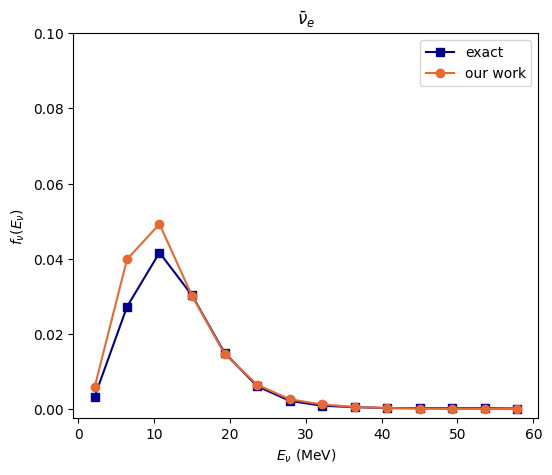

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nueb = np.loadtxt('spectrum_nueb_exact.txt', delimiter=',')


energy = data_exact_nueb[:, 0] 
f_values_exact_nueb = data_exact_nueb[:, 1]  
f_values_pinn_nueb = I0_nueb    

plt.figure(figsize=(6, 5))
plt.plot(energy, f_values_exact_nueb, marker='s',color=(0, 0, 139/255), linestyle='-', label='exact') 
plt.plot(energy, f_values_pinn_nueb, marker='o',color=(232/255, 105/255, 48/255), linestyle='-', label='our work')  
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=10)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=10)
plt.title(r'$\bar{\nu}_e$')
plt.ylim(top=0.1)
# plt.grid(True)
plt.legend()
plt.savefig("analytic_nueb.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


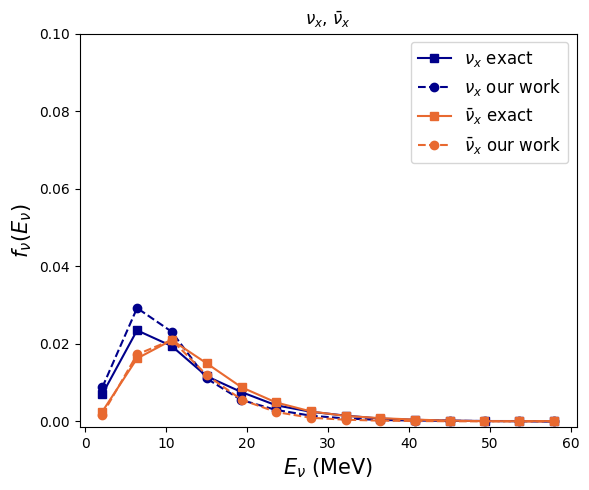

In [15]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nuxb = np.loadtxt('spectrum_nuxb_exact.txt', delimiter=',')
energy_nuxb = data_exact_nuxb[:, 0]
f_values_exact_nuxb = data_exact_nuxb[:, 1]
f_values_pinn_nuxb = I0_nuxb


data_exact_nux = np.loadtxt('spectrum_nux_exact.txt', delimiter=',')
energy_nux = data_exact_nux[:, 0]
f_values_exact_nux = data_exact_nux[:, 1]
f_values_pinn_nux = I0_nux


plt.figure(figsize=(6, 5))


plt.plot(energy_nux, f_values_exact_nux, marker='s', color=(0, 0, 139/255), 
         linestyle='-', label=r'$\nu_x$ exact')
plt.plot(energy_nux, f_values_pinn_nux, marker='o', color=(0, 0, 139/255), 
         linestyle='--', label=r'$\nu_x$ our work')



plt.plot(energy_nuxb, f_values_exact_nuxb, marker='s', color=(232/255, 105/255, 48/255), 
         linestyle='-', label=r'$\bar{\nu}_x$ exact')
plt.plot(energy_nuxb, f_values_pinn_nuxb, marker='o', color=(232/255, 105/255, 48/255), 
         linestyle='--', label=r'$\bar{\nu}_x$ our work')


plt.ylim(top=0.1)

plt.title(r'$\nu_x$, $\bar{\nu}_x$')
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=15)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=15)
# plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.savefig("analytic_nux&nuxb.pdf", format='pdf', bbox_inches='tight',dpi=300)
plt.show()

In [16]:
import numpy as np

import sys


def compute_delta_nu(f_exact, f_pinn):
    n_total = np.sum(f_exact)
    delta = np.sum((f_exact / n_total) * np.abs((f_pinn - f_exact) / f_exact))
    return delta


# nue
delta_nue = compute_delta_nu(f_values_exact_nue, f_values_pinn_nue)


# nuebar
delta_nueb = compute_delta_nu(f_values_exact_nueb, f_values_pinn_nueb)


# nux
delta_nux = compute_delta_nu(f_values_exact_nux, f_values_pinn_nux)


# nuxbar
delta_nuxb = compute_delta_nu(f_values_exact_nuxb, f_values_pinn_nuxb)


print(f"δ_nue = {delta_nue:.5e}")
print(f"δ_nueb = {delta_nueb:.5e}")
print(f"δ_nux = {delta_nux:.5e}")
print(f"δ_nuxb = {delta_nuxb:.5e}")
print(f"total = {delta_nue + delta_nueb + delta_nuxb + delta_nux}")


δ_nue = 2.05439e-01
δ_nueb = 1.93907e-01
δ_nux = 2.20062e-01
δ_nuxb = 1.95640e-01
total = 0.8150480081186684


In [17]:
import sympy as sp

expr_strings, var_names = analytic_model


variables = sp.symbols(var_names)  # (x_1, ..., x_11)


exprs = [sp.sympify(expr, locals={f'x_{i+1}': var for i, var in enumerate(variables)}) for expr in expr_strings]


F = sp.Matrix(exprs)

for i, expr in enumerate(exprs):
    print(f"\n--- f_{i+1} ---")
    print(expr.atoms(sp.Function, sp.Symbol, sp.Pow))





--- f_1 ---
{x_1, sin(x_7), x_4, x_0, x_6, sin(x_0), x_3, cos(x_3), sin(x_4), sin(x_2), x_2, sin(x_3), cos(x_1), x_7, sin(x_1), cos(x_7), cos(x_0), cos(x_4)}

--- f_2 ---
{sin(x_7), sin(x_0), cos(x_4), x_3, cos(x_6), cos(x_1), x_6, cos(x_3), sin(x_2), x_2, sin(x_1), cos(x_7), cos(x_0), sin(x_6), x_1, x_4, x_0, sin(x_3), x_7}

--- f_3 ---
{sin(x_7), x_5, sin(x_0), cos(x_5), cos(x_4), cos(x_2), cos(x_1), sin(x_5), x_6, sin(x_4), sin(x_2), x_2, sin(x_1), cos(x_7), cos(x_0), x_1, x_4, x_0, x_7}

--- f_4 ---
{sin(x_7), x_5, sin(x_0), cos(x_5), cos(x_4), cos(x_2), cos(x_6), cos(x_1), sin(x_5), x_6, sin(x_4), sin(x_2), x_2, sin(x_1), cos(x_7), cos(x_0), sin(x_6), x_1, x_4, x_0, x_7}

--- f_5 ---
{sin(x_7), cos(x_2), x_1, x_0, x_6, sin(x_0), cos(x_3), x_3, sin(x_2), x_2, cos(x_1), x_7, sin(x_1), cos(x_7), cos(x_0)}

--- f_6 ---
{sin(x_7), x_5, sin(x_0), cos(x_5), cos(x_2), x_3, cos(x_6), cos(x_1), sin(x_5), x_6, cos(x_3), sin(x_4), sin(x_2), x_2, sin(x_1), cos(x_7), cos(x_0), sin(x_6), x_1, x

In [18]:
for i, fi in enumerate(F):
    print(f"f_{i+1}(x) =", fi)


f_1(x) = -0.03362149745225906*x_0 + 0.06150002032518387*x_1 + 0.0003809592453762889*x_2 + 0.007929936051368713*x_3 - 0.001097792643122375*x_4 + 0.3408764898777008*x_6 - 0.0194508321583271*x_7 - 0.02033591270446777*sin(x_0) + 0.04621934145689011*sin(x_1) + 0.0003762061824090779*sin(x_2) + 0.006238061934709549*sin(x_3) - 0.001072634477168322*sin(x_4) - 0.01659741625189781*sin(x_7) + 0.03575641009956598*cos(x_0) - 0.03342309221625328*cos(x_1) + 0.0007248902693390846*cos(x_3) + 0.006039195694029331*cos(x_4) + 0.01507321186363697*cos(x_7) + 0.005836977157741785
f_2(x) = -0.03337496798485517*x_0 + 0.04082005843520164*x_1 - 0.00043690693564713*x_2 + 0.02755273506045341*x_3 + 0.06489140540361404*x_6 + 0.03575913608074188*x_7 + 0.01320024207234382*sin(x_0) + 0.02991908043622971*sin(x_1) - 0.0004356803256087005*sin(x_2) + 0.02499474957585335*sin(x_3) + 0.0603453628718853*sin(x_6) + 0.03037460148334503*sin(x_7) + 0.0244995728135109*cos(x_0) - 0.03008376061916351*cos(x_1) - 0.01282862853258848*cos

In [19]:
import sympy as sp

def filter_small_terms_deep(expr, threshold=1e-40):

    if expr.is_Mul:
        coeff = expr.as_coeff_Mul()[0]
        if abs(coeff) < threshold:
            return 0
        else:
            return sp.Mul(*[filter_small_terms_deep(a, threshold) for a in expr.args])

    elif expr.is_Add:
        terms = [filter_small_terms_deep(a, threshold) for a in expr.args]
        return sum(terms)

    elif expr.is_Pow:
        base = filter_small_terms_deep(expr.base, threshold)
        exp = filter_small_terms_deep(expr.exp, threshold)
        if base.is_Number and abs(base) < threshold:
            return 0
        return base**exp

    elif expr.is_Number:
        return expr if abs(expr) >= threshold else 0

    elif expr.is_Function:
        new_args = [filter_small_terms_deep(a, threshold) for a in expr.args]
        return expr.func(*new_args)
    else:
        return expr
    



In [20]:
F_filtered = [filter_small_terms_deep(fi, threshold=1e-8) for fi in F]


In [21]:
# F_filtered

In [22]:
sp.Matrix(F_filtered) 

Matrix([
[                                                                                                                                                           -0.03362149745225906*x_0 + 0.06150002032518387*x_1 + 0.0003809592453762889*x_2 + 0.007929936051368713*x_3 - 0.001097792643122375*x_4 + 0.3408764898777008*x_6 - 0.0194508321583271*x_7 - 0.02033591270446777*sin(x_0) + 0.04621934145689011*sin(x_1) + 0.0003762061824090779*sin(x_2) + 0.006238061934709549*sin(x_3) - 0.001072634477168322*sin(x_4) - 0.01659741625189781*sin(x_7) + 0.03575641009956598*cos(x_0) - 0.03342309221625328*cos(x_1) + 0.0007248902693390846*cos(x_3) + 0.006039195694029331*cos(x_4) + 0.01507321186363697*cos(x_7) + 0.005836977157741785],
[                                                                                                                                                                                      -0.03337496798485517*x_0 + 0.04082005843520164*x_1 - 0.00043690693564713*x_2 + 0.027552735060453

In [25]:
import sympy as sp


x_syms = sp.symbols("x1:12")  # x1 ~ x11
n_var = len(x_syms)

A = sp.Matrix.zeros(8, 11)


for i in range(8):
    A[i, i] = F_filtered[i]  

x_vec = sp.Matrix(x_syms)


V1_expr_by_matmul = A @ x_vec


# print("A =")
# sp.pprint(A)
# print("\nV1 = A @ x =")
# sp.pprint(V1_expr_by_matmul)


equal = V1_expr_by_matmul - sp.Matrix(F_filtered)



residual = sp.Matrix(F_filtered) - V1_expr_by_matmul

# print("\n residual =")
# sp.pprint(residual)


V1_reconstructed = V1_expr_by_matmul + residual
check = sp.simplify(V1_reconstructed - sp.Matrix(F_filtered))
print("\n V1_expr_by_matmul + residual =? V1:", check == sp.Matrix.zeros(8, 1))




 V1_expr_by_matmul + residual =? V1: True


In [24]:
A @ x_vec + residual - sp.Matrix(F_filtered)

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])